In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB4

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.7.0


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
IMAGE_SIZE = 128
EPOCHS = 20
BATCH = 8
LR = 1e-4

PATH = "Images/"

In [5]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "US images/*")))
    masks = sorted(glob(os.path.join(path, "Expert mask images/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [6]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  880
Validation data:  110
Testing data:  110


In [9]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

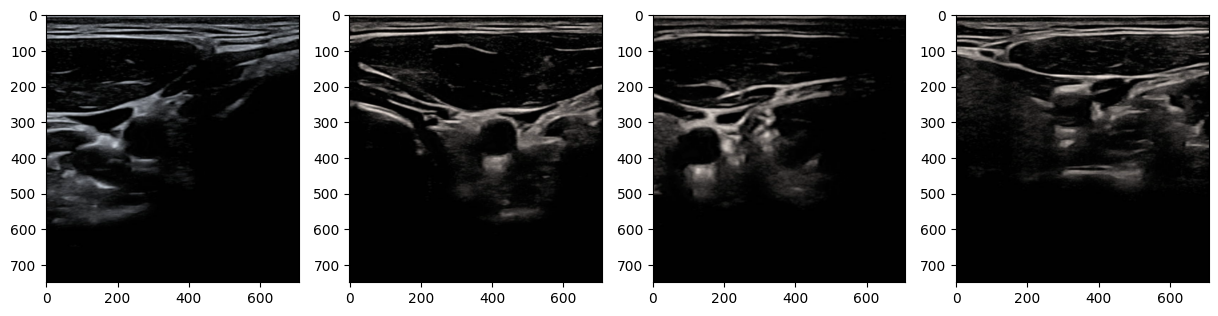

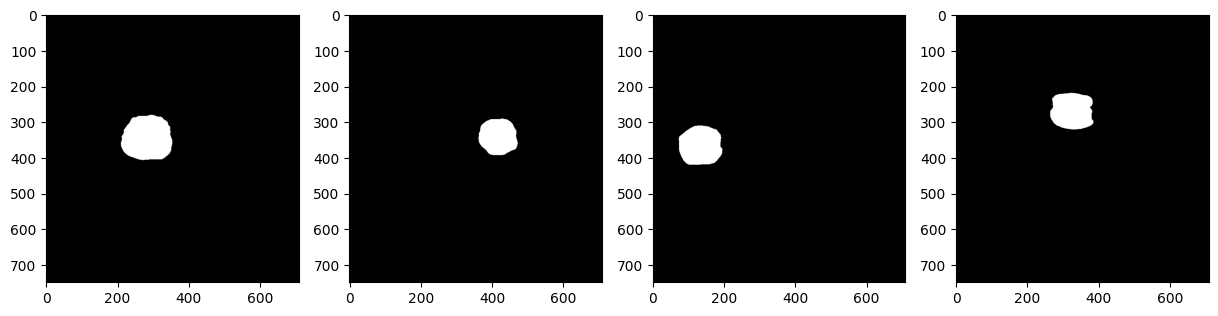

In [10]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB4

def attention_gate(input_1, input_2, n_filters):
    g1 = Conv2D(n_filters, kernel_size=1, use_bias=False)(input_1)
    x1 = Conv2D(n_filters, kernel_size=1, use_bias=False)(input_2)
    x2 = Conv2D(n_filters, kernel_size=1, use_bias=False)(input_2)
    psi = Add()([g1, x1])
    psi = Activation('relu')(psi)
    psi = Conv2D(1, kernel_size=1, use_bias=False)(psi)
    psi = Activation('sigmoid')(psi)
    x2 = Multiply()([x2, psi])
    return Add()([x1, x2])

def residual_block(inputs, n_filters):
    x = Conv2D(n_filters, kernel_size=3, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Add()([inputs, x])
    return Activation('relu')(x)

def create_model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model = EfficientNetB4(include_top=False, input_tensor=inputs, weights='imagenet')

    skip_connections = [
        base_model.layers[0].name,    # input layer
        'block2a_expand_activation',  # 64
        'block3a_expand_activation',  # 32
        'block4a_expand_activation',  # 16
        'block6a_expand_activation'   # 8
    ]
    
    encoder_output = base_model.get_layer('block7a_expand_activation').output
    
    f = [256, 64, 32, 16, 8]
    x = encoder_output
    
    for i in range(1, len(skip_connections)+1, 1):
        skip_conn = skip_connections[-i]
        skip_tensor = base_model.get_layer(skip_conn).output
        x = UpSampling2D(size=(2, 2))(x)
        x = attention_gate(x, skip_tensor, f[-i])
        x = residual_block(x, f[-i])
    
    x = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    
    model = Model(inputs, x)
    
    return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0]']      

In [12]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [13]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [14]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [15]:
filepath = 'C:\\Users\\NAGARAJ K\\U-Net'

In [16]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [17]:
callbacks = [
    checkpoint,
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [18]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
) 

Epoch 1/20
110/110 [==============================] - ETA: 0s - loss: 0.6691 - dice_coef: 0.3309 - recall: 0.6457 - precision: 0.1580
Epoch 00001: val_loss improved from inf to 0.96221, saving model to C:\Users\NAGARAJ K\U-Net
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\U-Net\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 790s 7s/step - loss: 0.6691 - dice_coef: 0.3309 - recall: 0.6457 - precision: 0.1580 - val_loss: 0.9622 - val_dice_coef: 0.0378 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/20
110/110 [==============================] - ETA: 0s - loss: 0.1574 - dice_coef: 0.8426 - recall: 0.9049 - precision: 0.9111
Epoch 00002: val_loss did not improve from 0.96221
110/110 [==============================] - 815s 7s/step - loss: 0.1574 - dice_coef: 0.8426 - recall: 0.9049 - precision: 0.9111 - val_loss: 0.9791 - val_dice_coef: 0.0209 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/20
110/110 [==============================] - ETA: 0s - loss: 0.1435 - dice_coef: 0.8565 - recall: 0.8912 - precision: 0.9006
Epoch 00003: val_loss did not improve from 0.96221
110/110 [==============================] - 850s 8s/step - loss: 0.1435 - dice_coef: 0.8565 - recall: 0.8912 - precision: 0.9006 - val_loss: 0.9865 -

E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 879s 8s/step - loss: 0.0804 - dice_coef: 0.9196 - recall: 0.9347 - precision: 0.9519 - val_loss: 0.8794 - val_dice_coef: 0.1188 - val_recall: 0.0796 - val_precision: 0.9986 - lr: 1.0000e-04
Epoch 5/20
110/110 [==============================] - ETA: 0s - loss: 0.0644 - dice_coef: 0.9356 - recall: 0.9434 - precision: 0.9590 
Epoch 00005: val_loss improved from 0.87944 to 0.41792, saving model to C:\Users\NAGARAJ K\U-Net
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\U-Net\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 1327s 12s/step - loss: 0.0644 - dice_coef: 0.9356 - recall: 0.9434 - precision: 0.9590 - val_loss: 0.4179 - val_dice_coef: 0.5808 - val_recall: 0.5123 - val_precision: 0.9806 - lr: 1.0000e-04
Epoch 6/20
110/110 [==============================] - ETA: 0s - loss: 0.0551 - dice_coef: 0.9449 - recall: 0.9468 - precision: 0.9634 
Epoch 00006: val_loss improved from 0.41792 to 0.18082, saving model to C:\Users\NAGARAJ K\U-Net
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\U-Net\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 1608s 15s/step - loss: 0.0551 - dice_coef: 0.9449 - recall: 0.9468 - precision: 0.9634 - val_loss: 0.1808 - val_dice_coef: 0.8184 - val_recall: 0.7898 - val_precision: 0.9176 - lr: 1.0000e-04
Epoch 7/20
110/110 [==============================] - ETA: 0s - loss: 0.0498 - dice_coef: 0.9502 - recall: 0.9496 - precision: 0.9664 
Epoch 00007: val_loss improved from 0.18082 to 0.08453, saving model to C:\Users\NAGARAJ K\U-Net
INFO:tensorflow:Assets written to: C:\Users\NAGARAJ K\U-Net\assets


E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 1838s 17s/step - loss: 0.0498 - dice_coef: 0.9502 - recall: 0.9496 - precision: 0.9664 - val_loss: 0.0845 - val_dice_coef: 0.9155 - val_recall: 0.9244 - val_precision: 0.9272 - lr: 1.0000e-04
Epoch 8/20
110/110 [==============================] - ETA: 0s - loss: 0.0471 - dice_coef: 0.9529 - recall: 0.9510 - precision: 0.9674 
Epoch 00008: val_loss did not improve from 0.08453
110/110 [==============================] - 2257s 21s/step - loss: 0.0471 - dice_coef: 0.9529 - recall: 0.9510 - precision: 0.9674 - val_loss: 0.6550 - val_dice_coef: 0.3445 - val_recall: 0.6276 - val_precision: 0.2609 - lr: 1.0000e-04
Epoch 9/20
110/110 [==============================] - ETA: 0s - loss: 0.0435 - dice_coef: 0.9565 - recall: 0.9527 - precision: 0.9701 
Epoch 00009: val_loss did not improve from 0.08453
110/110 [==============================] - 2200s 20s/step - loss: 0.0435 - dice_coef: 0.9565 - recall: 0.9527 - precision: 0.9701 - val_loss: 0.1401 - val_dic

E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 2213s 20s/step - loss: 0.0372 - dice_coef: 0.9628 - recall: 0.9565 - precision: 0.9752 - val_loss: 0.0715 - val_dice_coef: 0.9288 - val_recall: 0.9117 - val_precision: 0.9522 - lr: 1.0000e-05
Epoch 13/20
110/110 [==============================] - ETA: 0s - loss: 0.0363 - dice_coef: 0.9637 - recall: 0.9573 - precision: 0.9760 
Epoch 00013: val_loss did not improve from 0.07154
110/110 [==============================] - 2222s 20s/step - loss: 0.0363 - dice_coef: 0.9637 - recall: 0.9573 - precision: 0.9760 - val_loss: 0.0745 - val_dice_coef: 0.9260 - val_recall: 0.8803 - val_precision: 0.9755 - lr: 1.0000e-05
Epoch 14/20
110/110 [==============================] - ETA: 0s - loss: 0.0356 - dice_coef: 0.9644 - recall: 0.9576 - precision: 0.9768 
Epoch 00014: val_loss did not improve from 0.07154
110/110 [==============================] - 2286s 21s/step - loss: 0.0356 - dice_coef: 0.9644 - recall: 0.9576 - precision: 0.9768 - val_loss: 0.0775 - val_d

E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 2518s 23s/step - loss: 0.0350 - dice_coef: 0.9650 - recall: 0.9585 - precision: 0.9772 - val_loss: 0.0707 - val_dice_coef: 0.9298 - val_recall: 0.8857 - val_precision: 0.9766 - lr: 1.0000e-05
Epoch 17/20
110/110 [==============================] - ETA: 0s - loss: 0.0348 - dice_coef: 0.9652 - recall: 0.9582 - precision: 0.9777 
Epoch 00017: val_loss did not improve from 0.07070
110/110 [==============================] - 1985s 18s/step - loss: 0.0348 - dice_coef: 0.9652 - recall: 0.9582 - precision: 0.9777 - val_loss: 0.0723 - val_dice_coef: 0.9282 - val_recall: 0.8840 - val_precision: 0.9764 - lr: 1.0000e-05
Epoch 18/20
110/110 [==============================] - ETA: 0s - loss: 0.0344 - dice_coef: 0.9656 - recall: 0.9588 - precision: 0.9779 
Epoch 00018: val_loss did not improve from 0.07070
110/110 [==============================] - 2094s 19s/step - loss: 0.0344 - dice_coef: 0.9656 - recall: 0.9588 - precision: 0.9779 - val_loss: 0.0821 - val_d

E:\Anaconda\envs\Tensor\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Anaconda\envs\Tensor\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


110/110 [==============================] - 2011s 18s/step - loss: 0.0341 - dice_coef: 0.9659 - recall: 0.9587 - precision: 0.9782 - val_loss: 0.0600 - val_dice_coef: 0.9403 - val_recall: 0.9266 - val_precision: 0.9577 - lr: 1.0000e-05
Epoch 20/20
110/110 [==============================] - ETA: 0s - loss: 0.0339 - dice_coef: 0.9661 - recall: 0.9593 - precision: 0.9782 
Epoch 00020: val_loss did not improve from 0.05996
110/110 [==============================] - 1966s 18s/step - loss: 0.0339 - dice_coef: 0.9661 - recall: 0.9593 - precision: 0.9782 - val_loss: 0.0624 - val_dice_coef: 0.9379 - val_recall: 0.9189 - val_precision: 0.9605 - lr: 1.0000e-05


In [19]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

14/14 [==============================] - 85s 6s/step - loss: 0.0484 - dice_coef: 0.9515 - recall: 0.9373 - precision: 0.9695


[0.04836355894804001,
 0.9514932036399841,
 0.9372509717941284,
 0.9695025682449341]

In [20]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [21]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

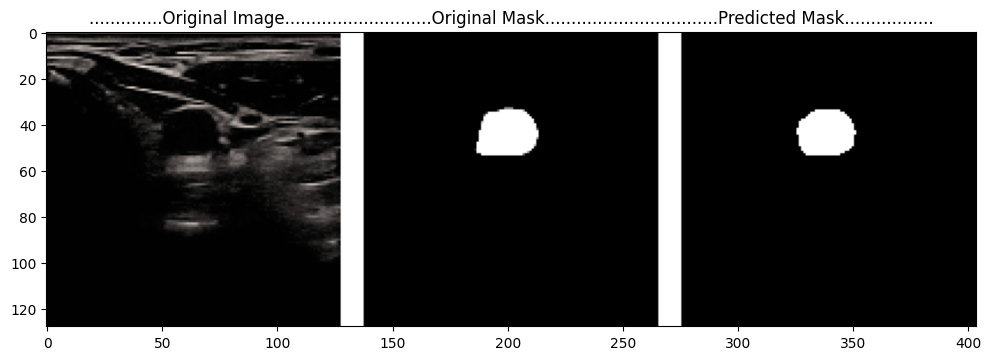

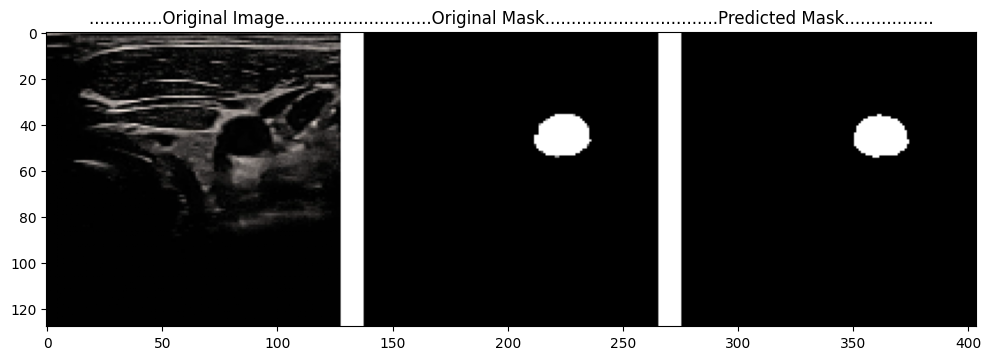

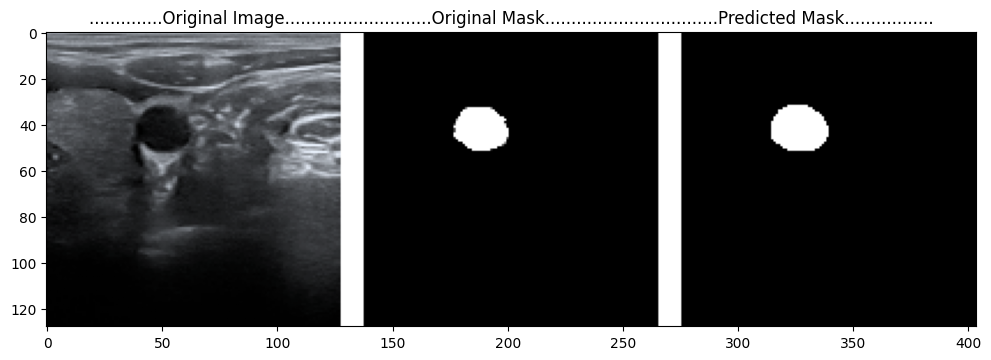

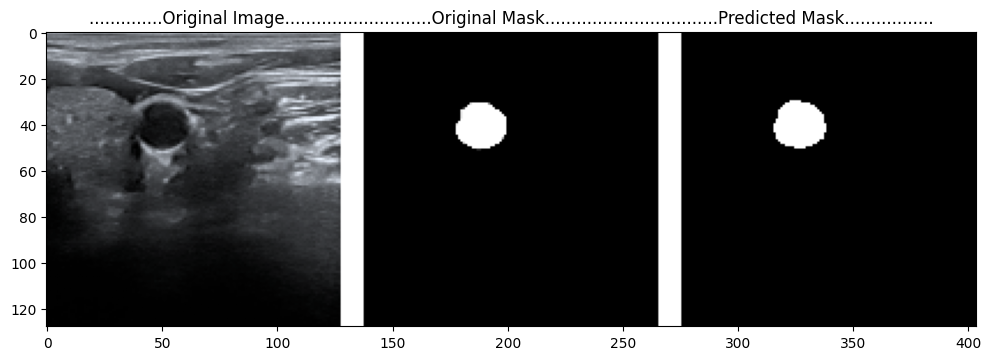

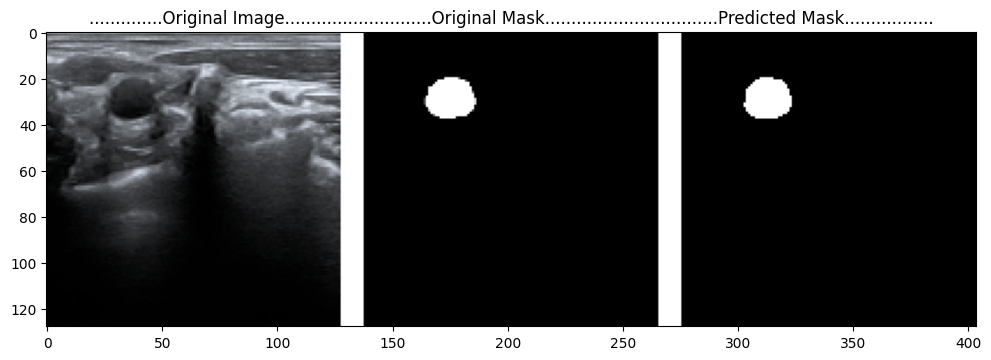

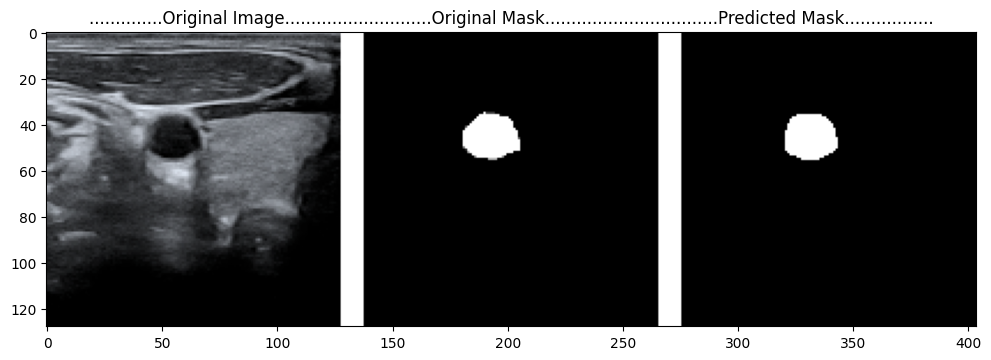

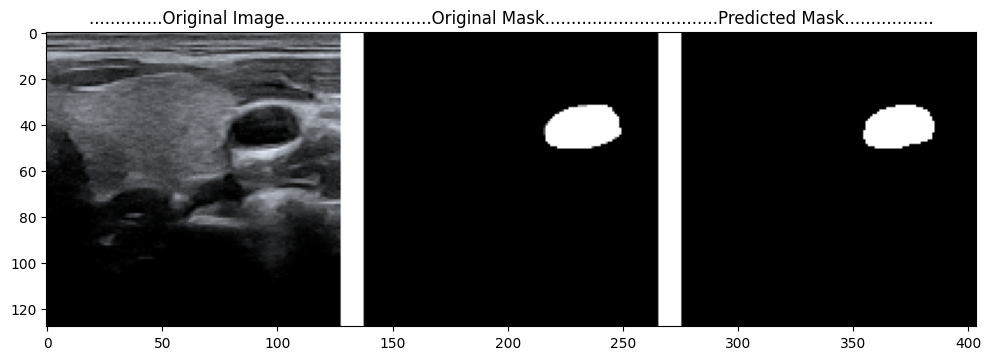

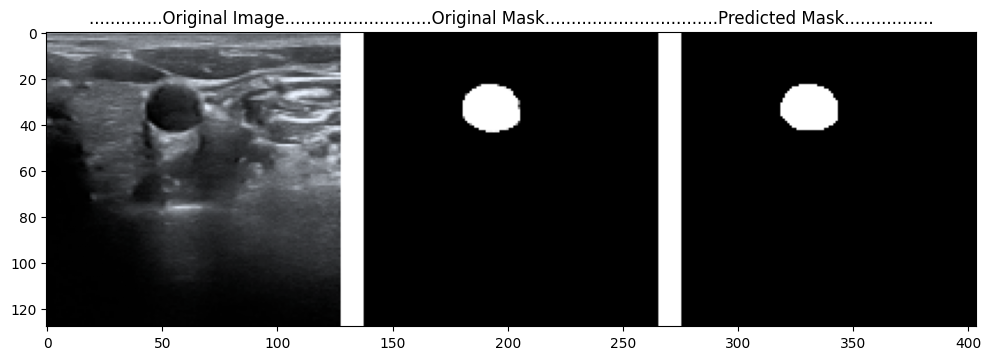

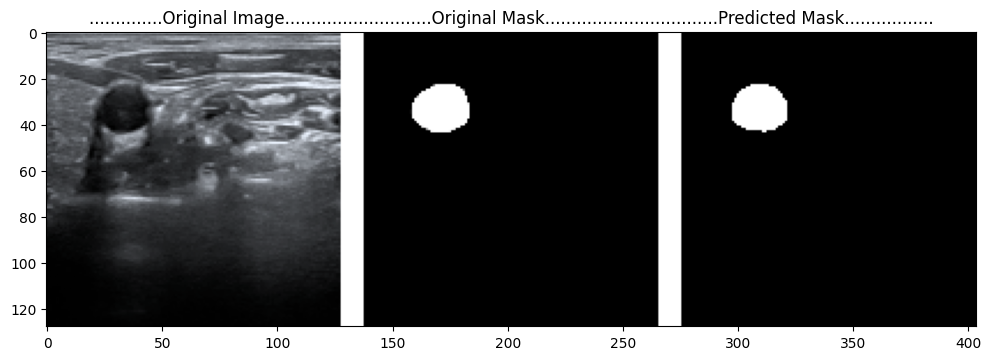

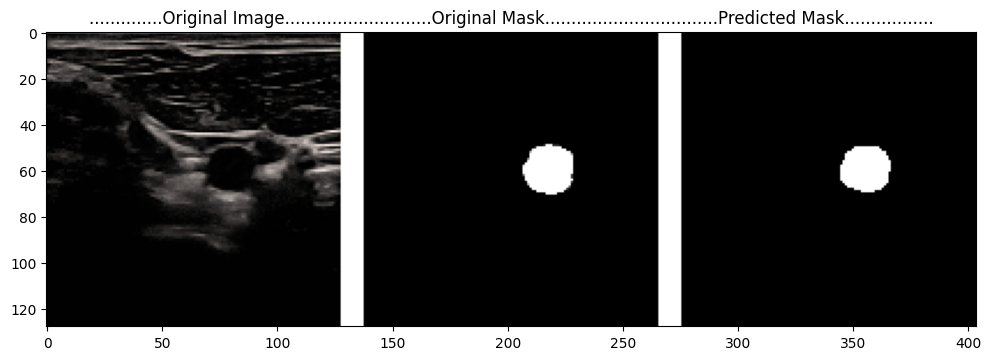

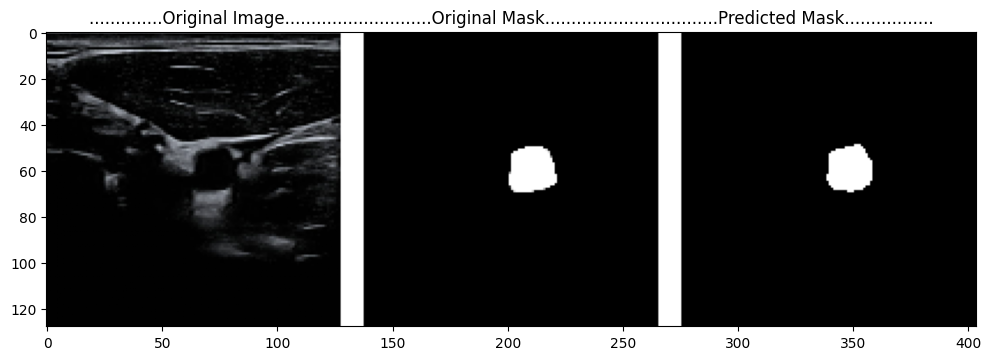

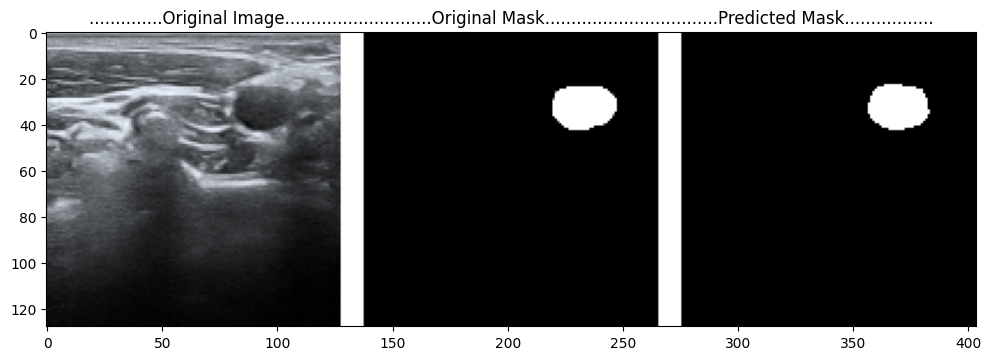

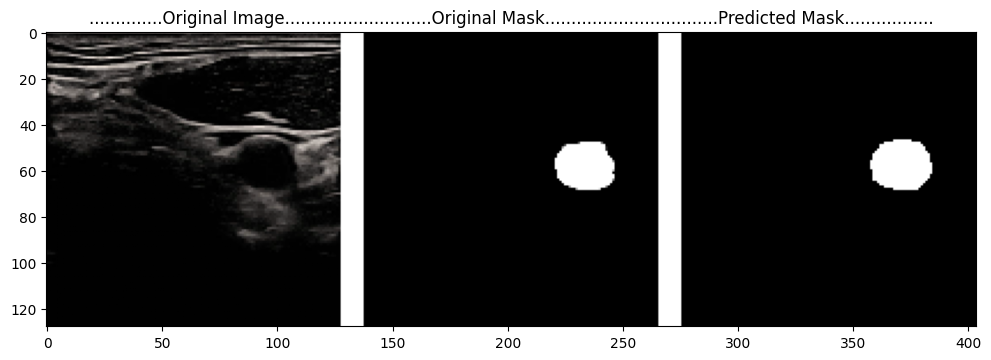

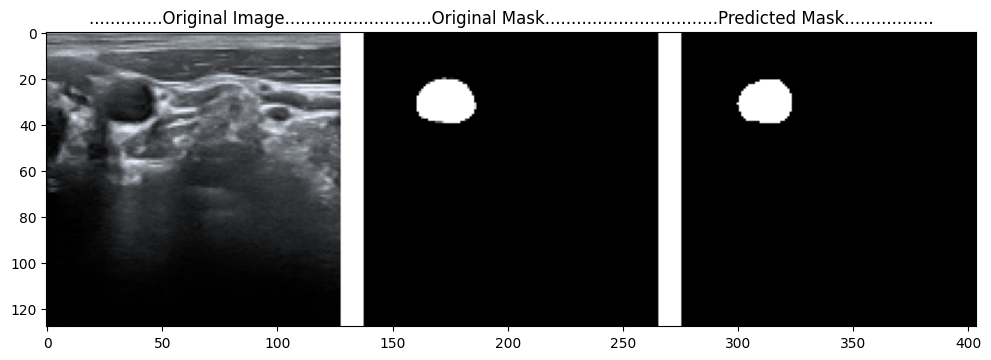

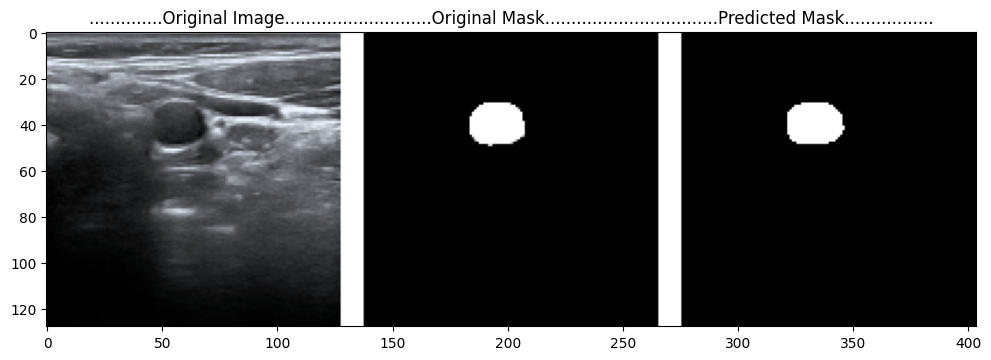

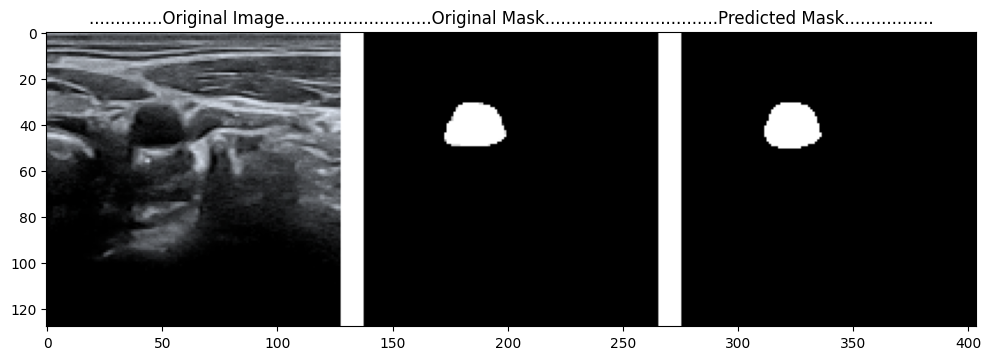

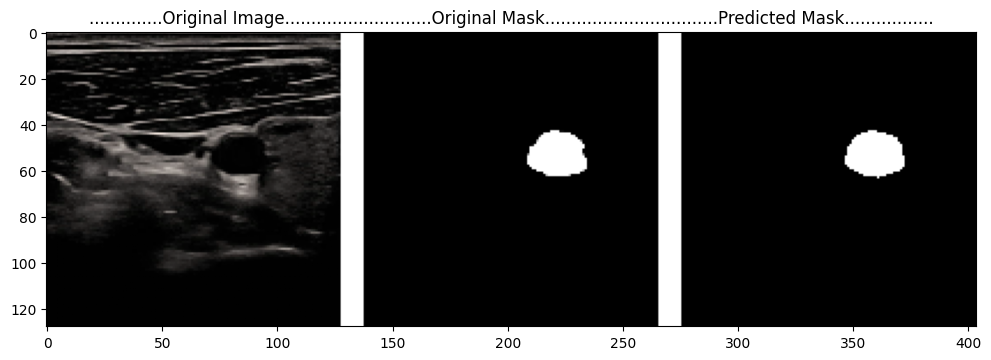

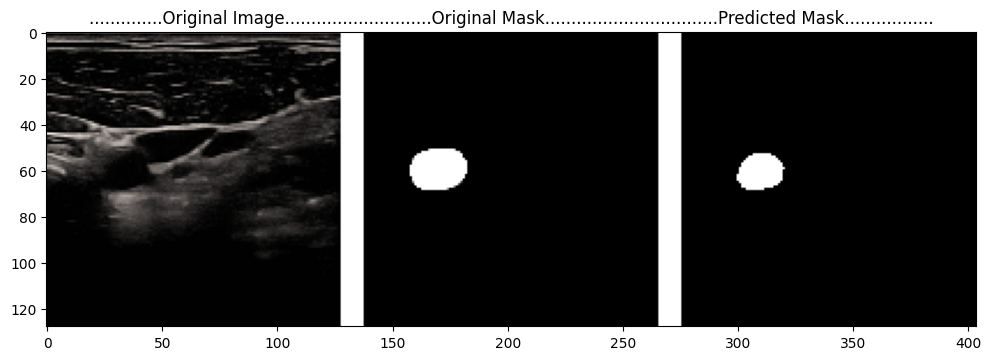

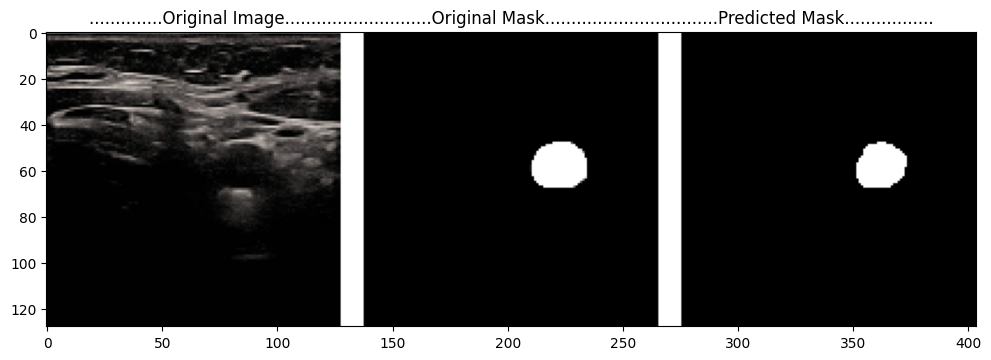

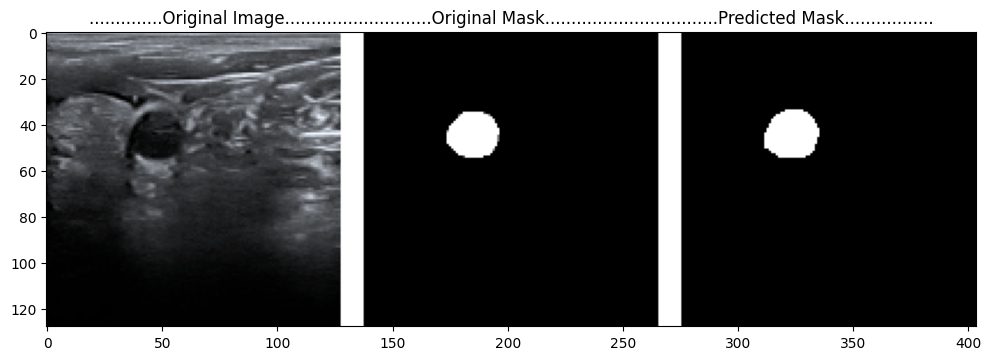

In [22]:
for i, (x, y) in enumerate(zip(test_x[:20], test_y[:20])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    a.set_title("____________Original Image________________________Original Mask_________________________Predicted Mask________________")
    a.set_title("..............Original Image............................Original Mask.................................Predicted Mask.................")
    imgplot = plt.imshow(image)